# AirBnB international price analysis 
# Joseph Tran
## 1. Data loading and cleaning
####    this section to how I loaded the data and took care of issues such as missing values, incorrect data types, and inconsistent formatting.
#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:

import pandas as pd
import numpy as np

# Load Beijing-Seattle Dataset
beijing_seattle = pd.read_csv("Data/beijing-seattle-airbnb-price.csv", sep='\t')
beijing_seattle.columns = ['city', 'price']
beijing_seattle['price'] = pd.to_numeric(beijing_seattle['price'], errors='coerce')
beijing_seattle = beijing_seattle.dropna()

# Load Bangkok Dataset
bangkok = pd.read_csv("Data/airbnb-bangkok-listings.csv")
bangkok = bangkok[['price', 'bedrooms', 'accommodates']].dropna()
bangkok['price'] = bangkok['price'].replace('[\$,]', '', regex=True)
bangkok['price'] = pd.to_numeric(bangkok['price'], errors='coerce')
bangkok_cleaned = bangkok.dropna(subset=['price'])
missing_prices_count = bangkok['price'].isnull().sum()
total_rows = bangkok.shape[0]

print(bangkok_cleaned.head())
print(beijing_seattle.head)




    price  bedrooms  accommodates
0  1845.0       1.0             3
1  1275.0       1.0             2
2   800.0       1.0             2
3   800.0       1.0             2
4  1845.0       1.0             2
<bound method NDFrame.head of         city  price
0    Beijing    401
1    Beijing    436
2    Beijing    479
3    Beijing    415
4    Beijing    317
..       ...    ...
990  Seattle    275
991  Seattle     75
992  Seattle     99
993  Seattle    140
994  Seattle    180

[995 rows x 2 columns]>


# Exploratory Data Analysis (EDA)
 I start by looking at descriptive statistics (mean, median, standard deviation, min, max) for each city's prices. This helps identify basic characteristics such as how prices differ between cities and how spread out the prices are. Next, I visualized the distributions using histograms to get a clearer picture of the price distributions. 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


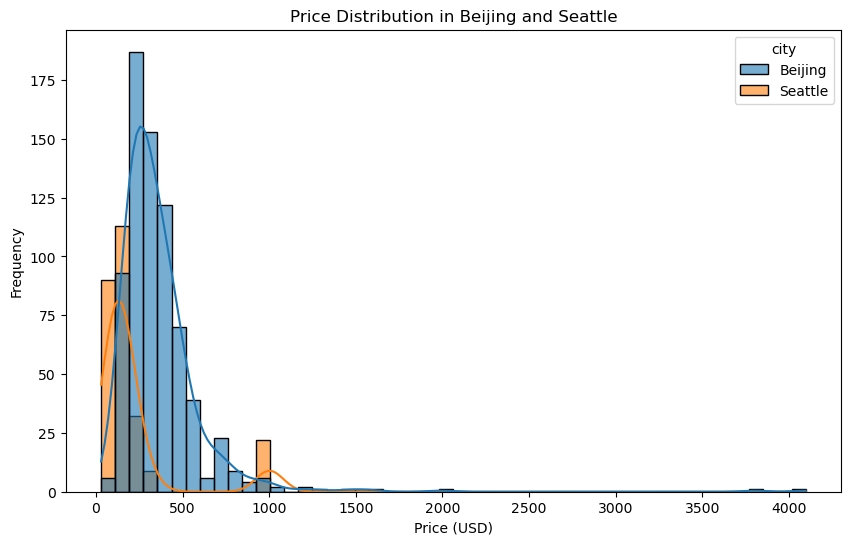

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


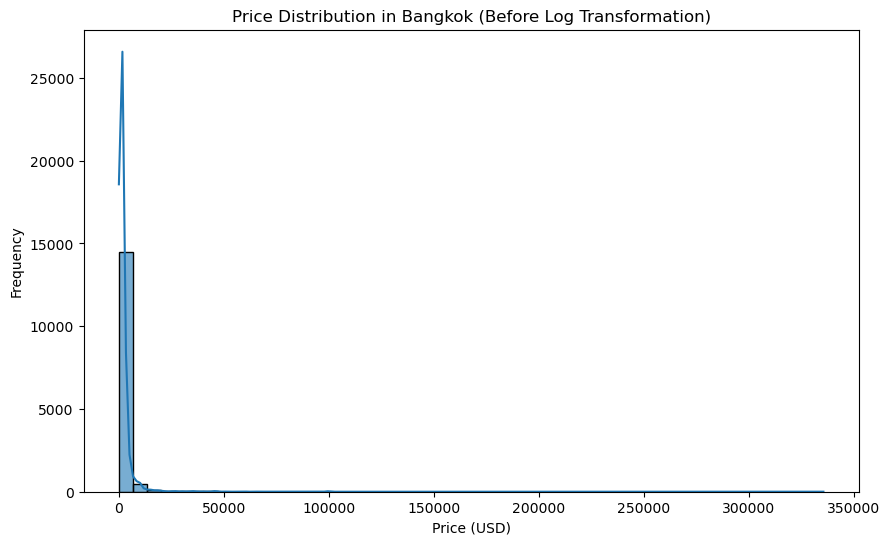

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize the distribution of prices for Beijing and Seattle
plt.figure(figsize=(10,6))
sns.histplot(data=beijing_seattle, x='price', hue='city', bins=50, kde=True, alpha=0.6)
plt.title('Price Distribution in Beijing and Seattle')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()
# Visualize the distribution of prices for bangkok
plt.figure(figsize=(10,6))
sns.histplot(data=bangkok_cleaned, x='price', bins=50, kde=True, alpha=0.6)
plt.title('Price Distribution in Bangkok (Before Log Transformation)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()


In this case, I saw that the price data was right-skewed (i.e., most of the listings are relatively cheap, with a few very expensive outliers). To handle this skewness, I applied a log transformation to the price data. This transformation makes the data more normally distributed, which is important for some of the statistical methods I plan to use later, such as t-tests and regression analysis. After the transformation, I visualized the distributions again to confirm the skewness had been reduced.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


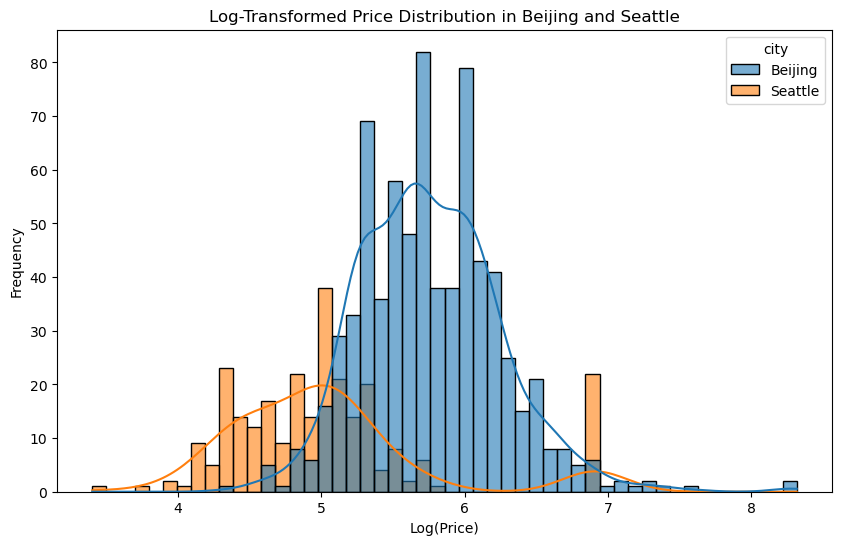

In [5]:
# Log-transform the price data due to skewness
beijing_seattle['log_price'] = np.log(beijing_seattle['price'])
bangkok_cleaned['log_price'] = np.log(bangkok_cleaned['price'])

# Visualize the log-transformed price distributions
plt.figure(figsize=(10,6))
sns.histplot(data=beijing_seattle, x='log_price', hue='city', bins=50, kde=True, alpha=0.6)
plt.title('Log-Transformed Price Distribution in Beijing and Seattle')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()


Beijing:
The distribution for Beijing is shifted to the right, indicating that Beijing generally has higher prices than Seattle. Most listings in Beijing are clustered around log prices of 5.5 to 6, corresponding to real prices between approximately $200 to $400.

Seattle:
The distribution for Seattle is shifted to the left, indicating that Seattle has lower prices compared to Beijing. The majority of listings are centered around log prices of 4.5 to 5, translating to real prices around $100 to $150.

price = e ^ log_price

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


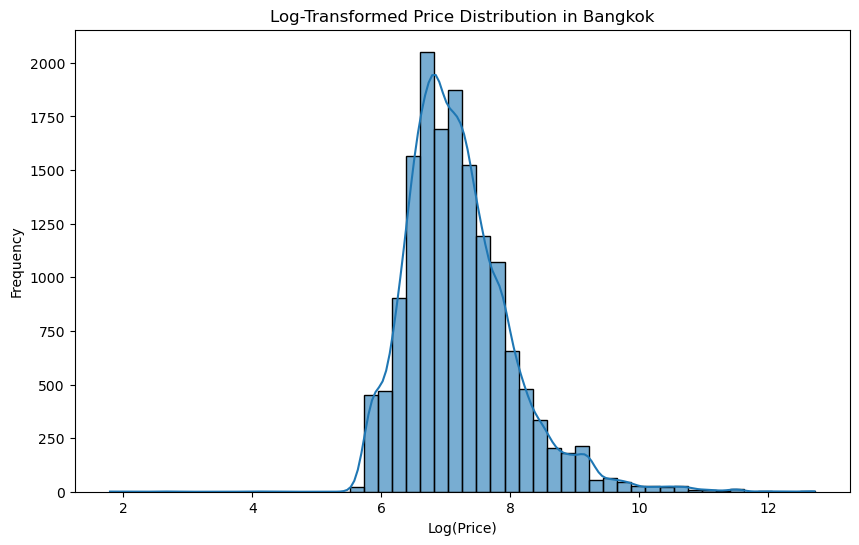

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(data=bangkok_cleaned, x='log_price', bins=50, kde=True, alpha=0.6)
plt.title('Log-Transformed Price Distribution in Bangkok')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

The distribution of log-transformed prices in Bangkok shows a strong peak around log prices of 7, indicating that most listings have prices concentrated around a certain range. This translates to real prices around $1,000 to $1,500. The distribution also has a long tail extending to the right, suggesting that there are some higher-priced listings in Bangkok, though these are fewer in number.

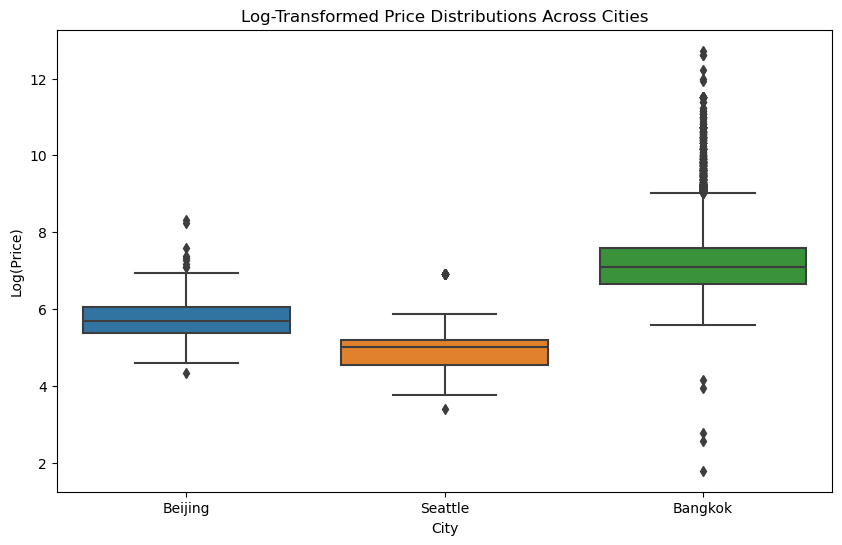

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the datasets
beijing_seattle['city'] = beijing_seattle['city']
bangkok_cleaned['city'] = 'Bangkok'

# Combine datasets for visualization
combined_data = pd.concat([beijing_seattle[['city', 'log_price']], bangkok_cleaned[['city', 'log_price']]], ignore_index=True)

# Create a boxplot to visualize price distributions
plt.figure(figsize=(10,6))
sns.boxplot(data=combined_data, x='city', y='log_price')
plt.title('Log-Transformed Price Distributions Across Cities')
plt.xlabel('City')
plt.ylabel('Log(Price)')
plt.show()

Bangkok has both high and low outliers with the high wining out, representing a few listings that are either much cheaper or much more expensive than the typical listing. This variability indicates that Bangkok's AirBnB market includes a lot of luxury options. I personally think this is due to it being a high tourism city.

# 3. Hypothesis Testing
#### Are the differences in AirBnB prices across Beijing, Seattle, and Bangkok statistically significant?
While we can observe that prices differ based on the boxplots, hypothesis testing allows us to provide quantitative evidence that these differences are not just due to random fluctuations in the data. 

The null hypothesis (H₀) is that there is no difference in the average prices between the two cities. The alternative hypothesis (H₁) is that there is a difference. By performing a ANOVA, we quantify how different the prices are and whether those differences are statistically significant. This way, we're not just assuming the differences are meaningful; we’re statistically proving that they are.


In [8]:
from scipy.stats import f_oneway

beijing_prices = beijing_seattle[beijing_seattle['city'] == 'Beijing']['log_price']
seattle_prices = beijing_seattle[beijing_seattle['city'] == 'Seattle']['log_price']
bangkok_prices = bangkok_cleaned['log_price']

# Perform a one-way ANOVA test
f_stat, p_val = f_oneway(beijing_prices, seattle_prices, bangkok_prices)

print(f'ANOVA test: F-statistic = {f_stat}, p-value = {p_val}')


ANOVA test: F-statistic = 1980.1976352431736, p-value = 0.0


The F-statistic is a ratio that compares the variance between the group means. With the F-statistic being so high indicates a large variance.

The p-value of 0.0 indicates that the probability of observing such a large F-statistic under the null hypothesis (that there are no differences between the groups) is extremely low. This  means that we have very strong evidence to reject the null hypothesis.

# 4. Multiple Linear Regression
### on bangkok dataset
I believe that Multiple Linear Regression is a good aproach for this data because a simpler method, such as simple linear regression, would only allow me to examine the relationship between price and one factor at a time. However, AirBnB pricing is influenced by many variables, and it would be misleading to look at each factor in isolation without accounting for others.
I want to see how different features (such as city, number of bedrooms, and accommodation size) affect AirBnB prices. The goal of this analysis is to understand how various independent variables contribute to the variation in the dependent variable, which in this case is the log-transformed price.

Dependent Variable: Log-transformed price (log_price).

Independent Variables: city, bedrooms, accommodates.

In [9]:
import statsmodels.api as sm
# Create dummy variables for accommodates and bedrooms
df_airbnb = bangkok_cleaned.copy()

# Categorize accommodates
def recode_accommodates(value):
    if value == 1:
        return "1"
    elif value == 2:
        return "2"
    elif value == 3:
        return "3"
    else:
        return "4 and more"

df_airbnb['accommodates_cat'] = df_airbnb['accommodates'].apply(recode_accommodates)

# Categorize bedrooms
def categorize_bedrooms(bedrooms):
    if bedrooms >= 4:
        return '4+'
    elif bedrooms >= 1:
        return str(int(bedrooms))
    else:
        return 'Unknown'

df_airbnb['bedrooms_cat'] = df_airbnb['bedrooms'].apply(categorize_bedrooms)

# Log-transform the price again for the expanded model
df_airbnb['log_price'] = np.log1p(df_airbnb['price'])

# Drop rows with missing values in bedrooms or accommodates
df_airbnb.dropna(subset=['bedrooms', 'accommodates'], inplace=True)

# Create dummy variables for the categorical variables (drop_first=True to avoid multicollinearity)
X = pd.get_dummies(df_airbnb[['bedrooms_cat', 'accommodates_cat']], drop_first=True).astype(int)

# Add a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable (log_price)
y = df_airbnb['log_price']

# Ensure X and y are properly aligned
X, y = X.align(y, join='inner', axis=0)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     706.2
Date:                Mon, 07 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:57:03   Log-Likelihood:                -16759.
No. Observations:               15200   AIC:                         3.353e+04
Df Residuals:                   15193   BIC:                         3.358e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Coefficients
### Constant (6.5947):
This number tells us the expected log-transformed price for a 1-bedroom listing that accommodates one person. It acts as the baseline, and we adjust from here depending on how many bedrooms and how many people the listing can accommodate.

### Bedrooms Categories:
- 2 bedrooms: Listings with 2 bedrooms are expected to have prices about 79.7% higher than listings with just 1 bedroom. We get this number by using the formula e^0.5862 ≈ 1.797, meaning that 2-bedroom listings are almost 80% more expensive than 1-bedroom ones.
- 3 bedrooms: Listings with 3 bedrooms have prices around 179.2% higher than 1-bedroom listings. The formula is e^1.0262 ≈ 2.792, so 3-bedroom properties are almost 180% more expensive.
- 4+ bedrooms: Listings with 4 or more bedrooms have prices 261.9% higher than 1-bedroom properties, which means they are more than 2.5 times more expensive.

### Accommodates Categories:
- Accommodates 2 people: Listings that can host 2 people are priced about 52.2% higher than listings for just 1 person (e^0.4200 ≈ 1.522).
- Accommodates 3 people: Listings that can host 3 people are about 63.1% more expensive than listings for 1 person (e^0.4894 ≈ 1.631).
- Accommodates 4 or more: Listings that can host 4 or more people are priced about 68.6% higher than listings for 1 person (e^0.5224 ≈ 1.686).
## Interpretation and Insights:

### Number of Bedrooms:
The more bedrooms a listing has, the more expensive it tends to be. Listings with 4 or more bedrooms are the most expensive, costing more than 2.5 times what 1-bedroom listings cost. This shows that room size (in terms of bedrooms) is a big factor in Airbnb pricing.

### Number of People the Listing Can Host:
Listings that can accommodate more people also tend to cost more. However, the price increase isn’t as big as the increase for adding bedrooms. For example, listings that accommodate 4 or more people are about 68.6% more expensive than listings that can only host 1 person.

### How Well the Model Explains Price Differences:
The R-squared value of 21.8% means that the number of bedrooms and accommodates explains about 21.8% of the differences in Airbnb prices. This means there are likely other important factors (like location or amenities) that we didn’t include, which also affect the price.

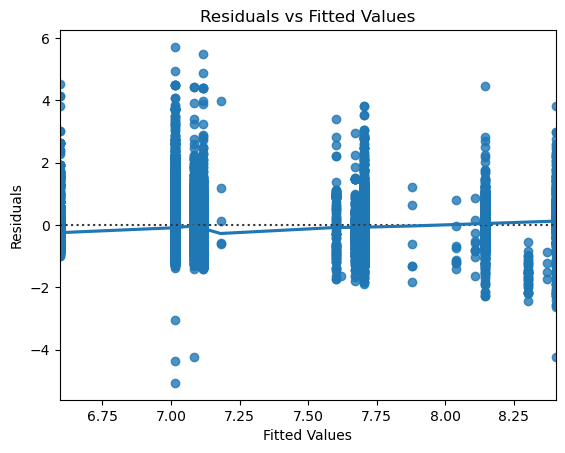

In [10]:
# Plot residuals vs fitted values to check for heteroscedasticity
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Ideally, the residuals should be scattered randomly around zero, without any clear pattern. Here, we see some clustering and vertical lines, which indicates that the model might be missing something or that the residuals are not perfectly random. This suggests heteroscedasticity (i.e., the residuals’ variance isn’t constant).

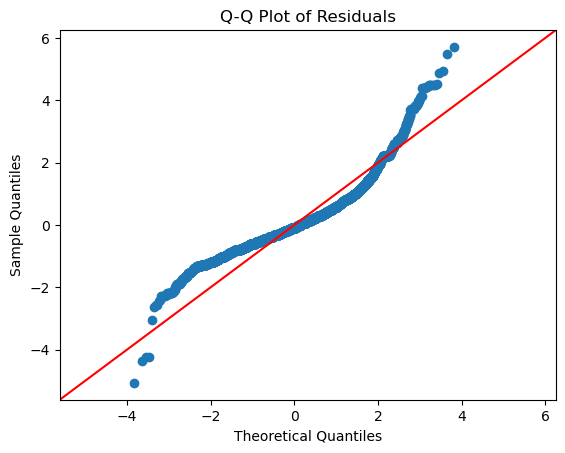

In [11]:
# Q-Q plot to check normality of residuals
sm.qqplot(model.resid, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()


Most residuals are close to the red line, but the tails (the points farthest from zero) deviate significantly. This suggests that while most of the residuals are normally distributed, there are outliers or extreme values that the model isn’t capturing well.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


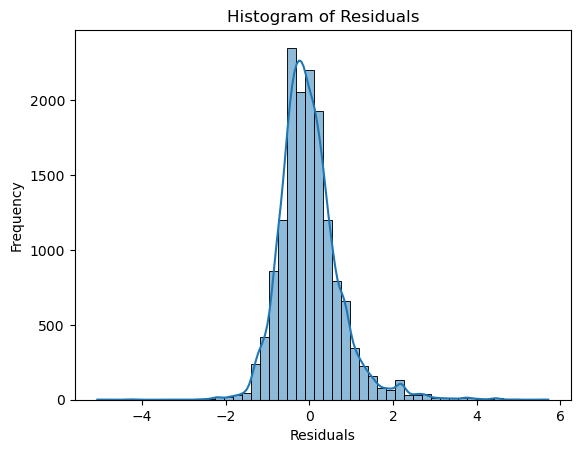

In [12]:
# Histogram of residuals
sns.histplot(model.resid, bins=50, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

The residuals are mostly centered around zero, but there is a bit of skew to the right. This matches the behavior seen in the Q-Q plot, where the extreme residuals deviate from normality. It also suggests the possibility of outliers or variables not captured well by the model.

### Overall Conclusion:
These plots suggest that the current model does a reasonable job of predicting prices but may need further refinements. Specifically, the model may not account for all the relevant variables, and there are signs of heteroscedasticity and non-normality in the residuals. Adding more features or transformations could help improve the fit and predictive power of the model.